<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">


# Recommender Systems: Item to Item

_Authors: David Yerrington(SF)_

This is a brief demonstration of how to take the concept of recommendation with an active "item" rather than an active "user".  A popular example would be a UI when you're looking at details of a given item/product/movie, you see **"People who liked this [item] also liked these [items]"**.

This is a great technique to use when you don't know preferences a user has, but you have user preferences for an item in context.  This item -> items like this.  Otherwise, the method we deep dive in with the lesson is more like "show me items from other people that are like me".

In [1]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt, seaborn as sns
import pandas as pd

from IPython.display import display

%matplotlib inline

In [2]:
users = [
    ("Chuck", 1, 1, 0, 0, 0, 0),
    ("Nancy", 1, 0, 0, 0, 1, 0),
    ("Divya", 0, 0, 0, 1, 1, 1),
    ("Pat", 0, 0, 1, 0, 1, 1),
]

users = pd.DataFrame(users, columns=["user", "Friday the 13th", "Nightmare on Elm St", "Dawn of the Dead", "Hiro Dreams of Sushi", "180 South", "Exit Through the Giftshop"])
users = users.set_index("user")
users

,Friday the 13th,Nightmare on Elm St,Dawn of the Dead,Hiro Dreams of Sushi,180 South,Exit Through the Giftshop
user,,,,,,
Chuck,1,1,0,0,0,0
Nancy,1,0,0,0,1,0
Divya,0,0,0,1,1,1
Pat,0,0,1,0,1,1


In [3]:
items = users.T
items

user,Chuck,Nancy,Divya,Pat
Friday the 13th,1,1,0,0
Nightmare on Elm St,1,0,0,0
Dawn of the Dead,0,0,0,1
Hiro Dreams of Sushi,0,0,1,0
180 South,0,1,1,1
Exit Through the Giftshop,0,0,1,1


### The Item Similarity Matrix

This matrix shows us similarity of items based on how users have rated them.  The quality if these relationships is as good as the data you have.  It's also a great point of investigation to see if similar items end up generally together.

Potential non-recommendation tasks on this type of data include:
- Dimensionality reduction
- Unsupervised clustering

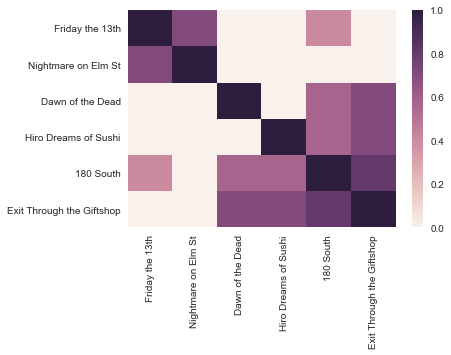

In [4]:
item_user_sim = pd.DataFrame( 
    cosine_similarity(items, items), 
    index   = items.index, 
    columns = items.index 
)
sns.heatmap(item_user_sim)

In [5]:
top_n_items = lambda title: item_user_sim.query("index == '%s'" % title).T.sort_values(title, ascending=False)
display("Top Similar Titles (based on user sim)", top_n_items("Friday the 13th"))
display("Common Users", items.T[items.query("index == 'Friday the 13th'").any(0)])

'Top Similar Titles (based on user sim)'

,Friday the 13th
Friday the 13th,1.000000
Nightmare on Elm St,0.707107
180 South,0.408248
Dawn of the Dead,0.000000
Hiro Dreams of Sushi,0.000000
Exit Through the Giftshop,0.000000


'Common Users'

,Friday the 13th,Nightmare on Elm St,Dawn of the Dead,Hiro Dreams of Sushi,180 South,Exit Through the Giftshop
user,,,,,,
Chuck,1,1,0,0,0,0
Nancy,1,0,0,0,1,0


![image.png](attachment:image.png)

This is good and all, but this method is still very "basic".  While powerful as **collaborative filtering** provides a realiable basis for providing recommendations, it's **limited by computational complexity**.  As the size of our element features and users grow, so does the cost of calculating the pairwise utility matrix.  At some point we might need to reduce the problem so it's faster to compute.  We can reduce this problem considerably using a decomposition method such as [SVD](https://www.youtube.com/watch?v=R9UoFyqJca8).  Adding SVD allows to generalize to a lower dimensional space, without sacrificing our ability to provide good results.  

SVD, is similar to PCA, and similarly it will find eigenvalues ranked by some order (SVD is also a possible step in PCA to decompose the covariance matrix).  With SVD, we are working within the framework of linear subspace.  Two orthoganal matrices, represent rotation and scaling that are used to calculate a diagonal term representing the square root of these ideas, rank ordered.

## $SVD = U\Sigma V^T$

A great video that also explains the idea of "concepts" in terms of SVD elements as it applies to recommender systems (item to item using user ratings), is [Lecture 47 — Singular Value Decomposition | Stanford University](https://www.youtube.com/watch?v=P5mlg91as1c).

Here is a template you can use for providing item-to-item collaborative filtering based recommendations with TruncatedSVD provided by sklearn.


#### Lets take care of some boring data handling 1st
Using the MovieLens dataset.  You may find it helpful to inspect the mereged dataframe, then look at it again after it's scaled.

In [6]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
import pandas as pd
import sqlite3
%matplotlib inline

# Load the data
ratings = pd.read_csv("./datasets/ml-latest-small/ratings.csv")
movies  = pd.read_csv("./datasets/ml-latest-small/movies.csv")
merged  = pd.merge(ratings,movies, how="left", on="movieId")

# Fill NaN with 0
user_ratings = merged.pivot_table(values="rating", index="userId", columns="title").fillna(0)

# Scale the ratings (anything greater than the mean ie: 0 == preferable movie rating)
scaler       = StandardScaler()
user_ratings_scaled = scaler.fit_transform(user_ratings)

# Update the user_ratings matrix as the standard scaled version of itself
user_ratings = pd.DataFrame(user_ratings_scaled, columns=user_ratings.columns)
user_ratings.head()

title,"""Great Performances"" Cats (1998)",$9.99 (2008),'Hellboy': The Seeds of Creation (2004),'Neath the Arizona Skies (1934),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),...,Zulu (1964),Zulu (2013),[REC] (2007),eXistenZ (1999),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931),İtirazım Var (2014)
0,-0.04447,-0.065067,-0.038633,-0.038633,-0.043135,-0.038633,-0.069429,-0.164403,-0.067015,-0.259634,...,-0.054677,-0.038633,-0.065867,-0.180215,-0.038633,-0.169689,-0.038633,-0.211519,-0.038633,-0.038633
1,-0.04447,-0.065067,-0.038633,-0.038633,-0.043135,-0.038633,-0.069429,-0.164403,-0.067015,-0.259634,...,-0.054677,-0.038633,-0.065867,-0.180215,-0.038633,-0.169689,-0.038633,-0.211519,-0.038633,-0.038633
2,-0.04447,-0.065067,-0.038633,-0.038633,-0.043135,-0.038633,-0.069429,-0.164403,-0.067015,-0.259634,...,-0.054677,-0.038633,-0.065867,-0.180215,-0.038633,-0.169689,-0.038633,-0.211519,-0.038633,-0.038633
3,-0.04447,-0.065067,-0.038633,-0.038633,-0.043135,-0.038633,-0.069429,-0.164403,-0.067015,-0.259634,...,-0.054677,-0.038633,-0.065867,-0.180215,-0.038633,-0.169689,-0.038633,-0.211519,-0.038633,-0.038633
4,-0.04447,-0.065067,-0.038633,-0.038633,-0.043135,-0.038633,-0.069429,-0.164403,-0.067015,-0.259634,...,-0.054677,-0.038633,-0.065867,-0.180215,-0.038633,-0.169689,-0.038633,-0.211519,-0.038633,-0.038633


#### Decompose to 12 components
Roughly based on movie genres but a longer inspection process can be useful to understand similar subsets of decomposed ratings to titles.

In [7]:
svd = TruncatedSVD(n_components=12, n_iter=7, random_state=42)
svd_ratings = svd.fit_transform(user_ratings.fillna(0).T)
svd_ratings.shape

(9064, 12)

#### Decompose to our utility matrix, from our SVD ratings matrix

In [8]:
U = pairwise_distances(svd_ratings, svd_ratings, metric="cosine")

#### Search for a title
We search the original ratings matrix for a title based on a substring match.  We do this to find an exact title name so we can select it with a mask later.

In this case, we are going to look for the original Leslie Nielson movie (totally a zanny movie BTW) from 1980 called "Airplane".

In [9]:
mask = user_ratings.columns.str.contains("Airplane")
user_ratings.columns[mask]

Index(['Airplane II: The Sequel (1982)', 'Airplane! (1980)'], dtype='object', name='title')

#### We know that the title is exactly 'Airplane! (1980)'

We can select the index cooresponding to the exact index for 'Airpline!(1980)', `target_movie`, look up it's vectors in the pairwise cosine distance matrix (ie: utility matrix U) that we will later merge with our titles matching the indices of the utility matrix.

In [10]:
target_movie = user_ratings.columns.tolist().index("Airplane! (1980)")
movie_sim = U[target_movie]

#### Now we attach the indices to the original ratings dataframe containing the titles to sort / display our recommendations based on "distance" (ie: difference).

We should see similar comedies centered around the 80s but this is based on latent characteristics of our original user preferences so they are still approximate.

> Similarity can be interpreted as $similarity\ =\ 1\ /\ (distance\ +\ 1)$.  A subtle difference but it does mean we add an extra complexity to our problem so this is why distance is preferable.  Distance is more efficient to calculate on it's own.

In [11]:
recs = pd.DataFrame(
    list(
        zip(user_ratings.columns.tolist(), movie_sim)
    ), 
    columns=["movie", "distance"]
)
recs.sort_values("distance").head(15)

,movie,distance
264,Airplane! (1980),0.000000
1691,Close Encounters of the Third Kind (1977),0.019921
3173,Ghostbusters (a.k.a. Ghost Busters) (1984),0.040252
2421,E.T. the Extra-Terrestrial (1982),0.040369
8671,Wayne's World (1992),0.041474
4203,Jaws (1975),0.043909
8893,"Wizard of Oz, The (1939)",0.044561
1041,Blazing Saddles (1974),0.046832
8085,This Is Spinal Tap (1984),0.050813
2831,"Fisher King, The (1991)",0.055541


#### How about a newer movie for comparison?

In [12]:
mask = user_ratings.columns.str.contains("Aveng")
user_ratings.columns[mask]

Index(['Avengers, The (1998)', 'Avengers, The (2012)',
       'Avengers: Age of Ultron (2015)',
       'Captain America: The First Avenger (2011)',
       'Toxic Avenger Part III: The Last Temptation of Toxie, The (1989)',
       'Toxic Avenger, Part II, The (1989)', 'Toxic Avenger, The (1985)'],
      dtype='object', name='title')

In [13]:
target_movie = user_ratings.columns.tolist().index("Avengers: Age of Ultron (2015)")
movie_sim = U[target_movie]

recs = pd.DataFrame(
    list(
        zip(user_ratings.columns.tolist(), movie_sim)
    ), 
    columns=["movie", "distance"]
)
recs.sort_values("distance").head(15)

,movie,distance
610,Avengers: Age of Ultron (2015),0.000000
5166,Men in Black III (M.III.B.) (M.I.B.³) (2012),0.002128
1167,"Bourne Legacy, The (2012)",0.004138
1415,Captain America: The Winter Soldier (2014),0.004892
2705,Fantastic Four: Rise of the Silver Surfer (2007),0.006162
8096,Thor: The Dark World (2013),0.016077
8467,Unstoppable (2010),0.018236
5714,No Strings Attached (2011),0.019197
7290,Snow White and the Huntsman (2012),0.019956
2469,Eight Legged Freaks (2002),0.022021


> Lastly, the metric provided by sklearn pairwise_distances are in "distance" so 0 is more similar than 1 (or more).